
foreground defense
==============================
ALI BORJI


In [3]:
%matplotlib inline

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
def load_model(net, model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    load_weights = torch.load(model_path, map_location=device)
    net.load_state_dict(load_weights)


In [7]:
from skimage import io, color, feature

def detect_edge_map(data):
    edge_maps = np.zeros_like(data)
    for idx,img in enumerate(data):
        edge_maps[idx,0] = feature.canny(np.array(img[0], dtype=np.float64), sigma = .1, low_threshold=1.5)

    return edge_maps
    

In [8]:
def plot_samples(epsilons, examples):
    # Plot several examples of adversarial samples at each epsilon
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

In [9]:
def add_noise_toimg(data):
  mask = data > 0

  # noise_data = np.random.rand(data.shape[0], data.shape[1], data.shape[2], data.shape[3])
  noise_data = np.random.rand(*data.shape)  
  noise_data[mask] = data[mask]

  return noise_data

In [22]:
def test_fgsm( model, device, test_loader, epsilon, extract_fg = False, add_noise=False, detect_edge=False):

    model.eval()
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
#     counter = 0 # counted the attack attemps
    for data, target in test_loader:

        
#         data_orig = torch.clone(data)
#         import pdb; pdb.set_trace()
        mask = np.zeros_like(data)
        mask[data > 0] = 1
        

        # add noise
        if add_noise:
            data = add_noise_toimg(data)
            data = torch.Tensor(data.tolist())
            
        data, target = data.to(device), target.to(device)        

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
#         if init_pred.item() != target.item():
#             continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # MULTIPLY THE ATTACK BY THE MASK; THAT IS REMOVE THE PERTURBATION ON BACKGROUND
        # import pdb; pdb.set_trace()
        if extract_fg:
#           import pdb; pdb.set_trace()      
          perturbed_data = perturbed_data.cpu().detach() * mask
#           print((data_orig[0,0] - perturbed_data[0,0]).sum())
#           perturbed_data = perturbed_data.to(device)
            
        if detect_edge:
            perturbed_data = detect_edge_map(perturbed_data.detach())
            

        perturbed_data = torch.Tensor(perturbed_data.tolist())            
        # Re-classify the perturbed image
        output = model(perturbed_data)
#         counter += 1

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
#     final_acc = correct/counter    
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
#     print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, counter, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples





## Load the model to be tested

In [11]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
# epsilons = [0, 8/255, 16/255, 32/255, 64/255]
# pretrained_model = "/gdrive/My Drive/Tmp/lenet_mnist_model.pth"
# pretrained_model = '/gdrive/My Drive/Tmp/cifar_net.pth' #pretrained_model = "lenet_mnist_model.pth"
# path = '/gdrive/My Drive/Tmp/slope_models/'

In [12]:
epsilons

[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

In [13]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


model = Net().to(device)  # training with slope 1 for now


In [14]:
from torchsummary import summary
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vgg = models.vgg16().to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [15]:
def add_noise_toimg(data):
  mask = data > 0

  # noise_data = np.random.rand(data.shape[0], data.shape[1], data.shape[2], data.shape[3])
  noise_data = np.random.rand(*data.shape)  
  noise_data[mask] = data[mask]

  return noise_data

In [16]:
# plt.imshow(d[40,0])
# plt.show()

In [17]:
d
xx = add_noise_toimg(data)
plt.imshow(xx[40,0])
plt.show()

NameError: name 'data' is not defined

In [18]:
# evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
# evaluate_x = evaluate_x / 255.0
# evaluate_y = test_loader.dataset.targets.type_as(torch.FloatTensor())

# evaluate_x = add_noise_toimg(np.array(evaluate_x)) # [:,None,...])))
# evaluate_x = torch.Tensor(evaluate_x)

# evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        

# model.eval()
# output = model(evaluate_x[:,None,...])
# pred = output.data.max(1)[1]
# d = pred.eq(evaluate_y.data).cpu()
# accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

# print('Accuracy:', accuracy*100)

On clean data

In [20]:
model = Net().to(device)  # training with slope 1 for now
orig_model = 'models/lenet_mnist_model.pth'
if os.path.exists(orig_model):
    load_model(model,orig_model)    
    print('model loaded')

evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
# evaluate_x = evaluate_x / 255.0
evaluate_y = test_loader.dataset.targets.type_as(torch.FloatTensor())

evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(14.2200, dtype=torch.float64)


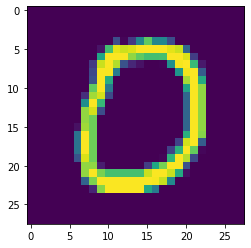

In [21]:
plt.imshow(evaluate_x[10].cpu()); plt.show()

In [35]:
# mask.shape

# Now perform adversarial attack

In [29]:
test_loader_new = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(), ])), batch_size=1, shuffle=True)


# load the orginal model  -----------------------------------------------------------------
# if model:
#     del model
model = Net().to(device)  # training with slope 1 for now
orig_model = 'models/mnist_gray.pth'
if os.path.exists(orig_model):
    load_model(model,orig_model)    
#     orig_model = torch.load(model_path, map_location=device)
    print('model loaded')

all_accs = []

# epsilons = epsilons[0:3]
epsilons = [.2]#[0, .05, .1, .15, .2, .25, .3]


accuracies, examples = [], []
extract_fg, add_noise, detect_edge = False, False, False
for eps in epsilons:
    acc, ex = test_fgsm(model, device, test_loader_new, eps, extract_fg, add_noise, detect_edge)
    accuracies.append(acc)
    examples.append(ex)
plot_samples(epsilons, examples)    
print(accuracies)
all_accs.append(accuracies)    




accuracies, examples = [], []
extract_fg, add_noise, detect_edge = False, True, False
for eps in epsilons:
    acc, ex = test_fgsm(model, device, test_loader_new, eps, extract_fg, add_noise, detect_edge)
    accuracies.append(acc)
    examples.append(ex)
plot_samples(epsilons, examples)    
print(accuracies)
all_accs.append(accuracies)    






accuracies, examples = [], []
extract_fg, add_noise, detect_edge = True, True, False
for eps in epsilons:
    acc, ex = test_fgsm(model, device, test_loader_new, eps, extract_fg, add_noise, detect_edge)
    accuracies.append(acc)
    examples.append(ex)
plot_samples(epsilons, examples)    
print(accuracies)
all_accs.append(accuracies)    




# xx


# load the model trained on edges now -----------------------------------------------------------------
model = Net().to(device)  # training with slope 1 for now
edge_model = 'models/mnist_edge.pth'
if os.path.exists(edge_model):
    load_model(model,edge_model)    
    print('model loaded')

    
accuracies, examples = [], []
extract_fg, add_noise, detect_edge = False, False, True
for eps in epsilons:
    acc, ex = test_fgsm(model, device, test_loader_new, eps, extract_fg, add_noise, detect_edge)
    accuracies.append(acc)
    examples.append(ex)
plot_samples(epsilons, examples)    
print(accuracies)
all_accs.append(accuracies)    


accuracies, examples = [], []
extract_fg, add_noise, detect_edge = False, True, True
for eps in epsilons:
    acc, ex = test_fgsm(model, device, test_loader_new, eps, extract_fg, add_noise, detect_edge)
    accuracies.append(acc)
    examples.append(ex)
plot_samples(epsilons, examples)    
print(accuracies)
all_accs.append(accuracies)    


accuracies, examples = [], []
extract_fg, add_noise, detect_edge = True, True, True
for eps in epsilons:
    acc, ex = test_fgsm(model, device, test_loader_new, eps, extract_fg, add_noise, detect_edge)
    accuracies.append(acc)
    examples.append(ex)
plot_samples(epsilons, examples)    
print(accuracies)
all_accs.append(accuracies)    





model loaded
> <ipython-input-22-9e6640418030>(15)test_fgsm()
-> mask = np.zeros_like(data)


(Pdb)  q


BdbQuit: 

In [61]:
os.path.exists(orig_model)

True

# Plot results

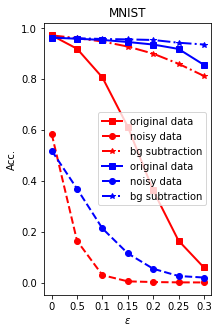

In [257]:
data_mnist = np.array([[0.9726, 0.9199, 0.8069, 0.6131, 0.3625, 0.1649, 0.0592],
[0.5846, 0.1641, 0.0291, 0.0046, 0.0019, 0.0006, 0.0003],
[0.9726, 0.9616, 0.9485, 0.9285, 0.9007, 0.8608, 0.8131],
[0.9637, 0.9593, 0.9545, 0.9465, 0.9365, 0.9192, 0.8567],
[0.519, 0.3687, 0.2128, 0.1147, 0.0543, 0.0257, 0.0196],
[0.9637, 0.9613, 0.9583, 0.9567, 0.9544, 0.9436, 0.9366]])

# repeat for each one u want
# aa = pgd_all[:,1]
symbs = ['r-s','r--o', 'r-.*', 'b-s','b--o', 'b-.*']
legs = ['original data', 'noisy data', 'bg subtraction', 'original data', 'noisy data', 'bg subtraction']

fig, ax = plt.subplots(figsize=(3,5))

for i in np.arange(data_mnist.shape[0]):
    plt.plot(data_mnist[i],symbs[i], linewidth=2, markersize=6)
    plt.xticks(np.arange(7), ['0', '0.5', '0.1', '0.15', '0.2', '0.25', '0.3'])
#     plt.set_xticklabels(['0', '8', '32'])

# plt.set_xticks(list(np.arange(4)))    
plt.legend(legs)
plt.xlabel('$\epsilon$')
plt.ylabel('Acc.')
plt.title('MNIST')
plt.show()

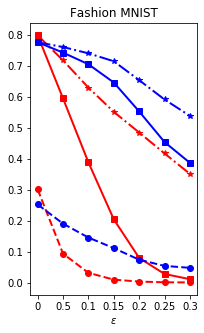

In [255]:
data_mnistfashion = np.array([[0.7979, 0.5941, 0.388, 0.204, 0.0796, 0.0277, 0.0108],
[0.3006, 0.093, 0.0314, 0.0093, 0.0031, 0.0008, 0.0003],
[0.7979, 0.7171, 0.6291, 0.551, 0.4843, 0.4169, 0.3508],
[0.7755, 0.7422, 0.7046, 0.6457, 0.5524, 0.4536, 0.3865],
[0.2521, 0.19, 0.1452, 0.1111, 0.0737, 0.0537, 0.0475],
[0.7755, 0.7602, 0.7399, 0.7143, 0.6533, 0.5909, 0.538]])

# repeat for each one u want
# aa = pgd_all[:,1]
symbs = ['r-s','r--o', 'r-.*', 'b-s','b--o', 'b-.*']
legs = ['clean data', 'noisy data', 'bg subtraction', 'clean data', 'noisy data', 'bg subtraction']

fig, ax = plt.subplots(figsize=(3,5))

for i in np.arange(data_mnistfashion.shape[0]):
    plt.plot(data_mnistfashion[i],symbs[i], linewidth=2, markersize=6)
    plt.xticks(np.arange(7), ['0', '0.5', '0.1', '0.15', '0.2', '0.25', '0.3'])
#     plt.set_xticklabels(['0', '8', '32'])

# plt.set_xticks(list(np.arange(4)))    
# plt.legend(legs)
plt.xlabel('$\epsilon$')
# plt.ylabel('Acc.')
plt.title('Fashion MNIST')
plt.show()

NameError: name 'accuracies' is not defined

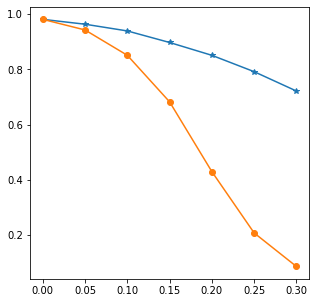

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_clean, "*-")
plt.plot(epsilons, accuracies_clean_orig, "o-")
plt.plot(epsilons, accuracies, "*--")
plt.plot(epsilons, accuracies_orig, "o--")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05)*255)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(['with bg masking (clean)', 'w/o bg masking (clean)', 'with bg masking (noise)', 'w/o bg masking (noise)'], loc='center left')
plt.show()